In [1]:
# In this notebook, we will combine Conv2D with
# logarithmic and exponential functions to assimilate
# different type of kernels, such as Laplace, RBF, 
# Multipying, Deviding, etc.
# for "Retina Blood Vessel" dataset
#

In [2]:
# Kernels
# 
# exp(log(x) + log(y)) = x * y
# exp(log(x) - log(y)) = x / y
# exp(-|x - y|) = 
#     x > y -> exp(-x + y) = exp(-x) * exp(y) = exp(y) / exp(x)
#     x < y -> exp(x - y) = exp(x) * exp(-y) = exp(x) / exp(y)
# exp(log(|x|) + log(|y|)) = |x| * |y|

In [3]:
# imports
#
import sys
import os
import glob
import time
import copy
import numpy as np
import scipy as sp
import skimage
from skimage import segmentation, io, filters, morphology
import sklearn
from sklearn import ensemble, metrics, svm
import matplotlib.pyplot as plt
import plotly
import plotly.subplots
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

import torch, torchvision

from IPython.core.debugger import set_trace

/home/khalkhaliv/Projects/mytorch/lib64/python3.9/site-packages/torchvision/io/image.py:13: UserWarning:

Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory



In [4]:
# Globals
#
train_image_ipath = 'RetinaBloodVessels/train/image/'
train_mask_ipath = 'RetinaBloodVessels/train/mask/'
test_image_ipath = 'RetinaBloodVessels/test/image/'
test_mask_ipath = 'RetinaBloodVessels/test/mask/'
NROWS, NCOLS = 512, 512
EPSILON = 1e-6
br = set_trace

In [8]:
# read all images and masks and store in two matrices
train_images = read_images(train_image_ipath)
train_masks = 1 * (read_images(train_mask_ipath, rescale=False) > 0)
test_images = read_images(test_image_ipath)
test_masks = 1 *(read_images(test_mask_ipath, rescale=False) > 0)
print(train_images.shape, train_masks.shape,
      test_images.shape, test_masks.shape)
print(train_images.min(), train_images.max(), train_images.mean())
print(train_masks.min(), train_masks.max(), train_masks.mean())

(80, 512, 512, 3) (80, 512, 512) (20, 512, 512, 3) (20, 512, 512)
-1.5989004704853944 4.097728417232479 1.5034270125132329e-18
0 1 0.12315158843994141


In [9]:
# functions and classes

def read_images(path, rescale=True):
    images_fnames = sorted(glob.glob(os.path.join(path, '*.png')))
    images = []
    for fn in images_fnames:
        img = io.imread(fn)
        if rescale:
            img = np.float64(img)
            # Min-Max
            # img = (img - img.min()) / (img.max() + EPSILON)
            # img = 2*img - 1
            # img = np.float64(img)/img.max()
            # Normalization
            img = (img - img.mean()) / img.std()
        images.append(img)
    images = np.array(images)
    return images

def gray(img):
    gr = img.mean(axis=2)
    gr = (gr - gr.min()) / (gr.max() - gr.min() + EPSILON)
    return gr

def show(img):
    if img.max != 255:
        img = np.float64(img)
        img = np.uint8(255*(img - img.min())/(img.max()-img.min() + EPSILON))
    fig = plt.figure(figsize=(5, 5))
    ax = fig.subplots()
    ax.imshow(img, cmap='gray')
    return True

class Poly(torch.nn.Module):
    def __init__(self, degree):
        super().__init__()
        self.degree = degree
    def extra_repr(self):
        return f'{self.degree}'
    def forward(self, x):
        out = x**self.degree
        if out.isnan().any() | out.isinf().any():
            br()
        return out

class Concat(torch.nn.Module):
    def __init__(self, ops: list = []):
        super().__init__()
        self.ops = torch.nn.ModuleList()
        self.ops += ops
    def append(self, op):
        self.ops.append(op)
        return self
    def forward(self, x):
        # br()
        comb = [op(x) for op in self.ops]
        out = torch.concatenate(comb, dim=1)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class Exp(torch.nn.Module):
    def __init__(self):
        super(Exp, self).__init__()
    def forward(self, x):
        out = torch.exp(x)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class Log(torch.nn.Module):
    def __init__(self):
        super(Log, self).__init__()
    def forward(self, x):
        out = torch.log(x.abs() + EPSILON)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class Laplacian(torch.nn.Module):
    """
    RBF's Kernel between chunks of nch channel
    """
    def __init__(self, nch):
        super().__init__()
        self.nch = nch
        self.epsilon = EPSILON
        self.slope = torch.nn.Parameter(torch.randn(1),
                                        requires_grad=True)
    def extra_repr(self):
        return (f'{self.nch}, ' +
                f'{self.slope.item():.4f}')
    def forward(self, x):
        """
        x: should be (batch, channel, ...)
        """
        with torch.no_grad():
            while (((x + self.epsilon) == 0.0).any() | 
                   (self.epsilon < 1e-8)):
                self.epsilon = EPSILON * torch.randn(1).item()
        out = []
        for c1 in range(0, x.shape[1] // self.nch - 1):
            for c2 in range(c1+1, x.shape[1] // self.nch):
                slc1 = slice(c1*self.nch, (c1+1)*self.nch)
                slc2 = slice(c2*self.nch, (c2+1)*self.nch)
                rbf = torch.exp(
                    -(self.slope*(x[:, slc1, :, :]-x[:, slc2, :, :])).abs())
                out.append(rbf)
        out = torch.concatenate(out, dim=1)
        if out.isnan().any() | out.isinf().any():
            print(self)
            br()
        return out

class JaccardLoss(torch.nn.Module):
    def __init__(self, smooth=1, weight=None, size_average=True):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        smooth = self.smooth

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        # flatten label and prediction tensors
        # inputs = inputs.view(-1)
        # targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        jac = (intersection + smooth)/(union + smooth)
        
        return -torch.log(jac)
        # return 1 - jac

class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        smooth = self.smooth

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        # flatten label and prediction tensors
        # inputs = inputs.view(-1)
        # targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return -torch.log(dice)
        # return 1 - dice

# Dice Binary Cross Entropy Coefficient
class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        # inputs = inputs.view(-1)
        # targets = targets.view(-1)
        inputs, targets = inputs.flatten(), targets.flatten()

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
    
class Train:
    """
    Initialize, train, evaluate, decode
    """
    def __init__(self, model, data, label, nepoch=4, bsize=8):
        """
        data: [batch, num_channel, rows, cols]
        label: [batch, num_channel, rows, cols]
        """
        self.model = model
        self.data = data
        self.label = label
        self.nepoch = nepoch
        self.device = (torch.device("cuda:0")
                       if torch.cuda.is_available()
                       else torch.device('cpu'))
        print('Device: ', self.device)
        # weight = torch.Tensor([label.sum()/label.numel(),
        #                        1-label.sum()/label.numel()])
        # print('Weight: ', weight)
        # self.crit = torch.nn.CrossEntropyLoss(weight=weight.to(self.device))
        # self.crit = DiceLoss(smooth=0.0)
        # self.crit = DiceBCELoss()
        self.crit = JaccardLoss(smooth=0.0)
        self.bsize = bsize
    def run(self, lr=1e-4):
        bmodel, bloss = self.model, float('inf')
        model = self.model
        model = model.to(self.device)
        crit = self.crit
        optim = torch.optim.Adam(model.parameters(), lr=lr)
        # sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #     optim, factor=0.5, patience=4, threshold=0.001)
        t1 = time.time()
        for epoch in range(self.nepoch):
            # t1 = time.time()
            model, optim = self._train(model, crit, optim)
            
            loss = self._valid(model, crit)
            # sch.step(loss)
            # if lr != optim.param_groups[0]['lr']:
            #     lr = optim.param_groups[0]['lr']
            #     print(f'Learning rate changed to {lr:.04f}.')
            if (epoch % 10 == 0) | (epoch == (self.nepoch-1)):
                print(f'Ep: {epoch+1}, Secs: {time.time() - t1:.0f}, ' +
                      f'loss: {loss:.04f}')
                t1 = time.time()
            if loss < bloss:
                bmodel, bloss = copy.deepcopy(model), loss
        return bmodel, bloss
            
    def _train(self, model, crit, optim):
        model.train()
        for bc in range(1, self.data.shape[0] // self.bsize + 1 +
                        1*(self.data.shape[0] % self.bsize != 0)):
            slc = slice((bc-1)*self.bsize, bc*self.bsize)
            batch, lb = self.data[slc, :, :, :], self.label[slc].long()
            batch, lb = batch.to(self.device), lb.to(self.device)
            optim.zero_grad()
            out = model(batch)
            # out = out.softmax(dim=1)
            # loss = crit(out, lb)
            # loss = crit(out.swapaxes(1, 2).swapaxes(2, 3).flatten(0, 2),
            #             lb.flatten())
            # loss = crit(out[:, 1, :, :], lb.float())
            loss = crit(out, lb.float())
            loss.backward()
            optim.step()
        return model, optim
    
    def _valid(self, model, crit):
        model = model.to(self.device)
        model.eval()
        loss_sum = 0.0
        with torch.no_grad():
            for bc in range(1, self.data.shape[0] // self.bsize + 1 +
                            1*(self.data.shape[0] % self.bsize != 0)):
                slc = slice((bc-1)*self.bsize, bc*self.bsize)
                batch, lb = self.data[slc], self.label[slc]
                batch, lb = batch.to(self.device), lb.to(self.device).long()
                out = model(batch)
                # out = out.softmax(dim=1)
                # loss = crit(out, lb)
                # loss = crit(out.swapaxes(1, 2).swapaxes(2, 3).flatten(0, 2),
                #             lb.flatten())
                loss = crit(out, lb.float())
                loss_sum += loss.item()
        return loss_sum / bc

    def decode(self, model):
        model = model.to(self.device)
        model.eval()
        decs = []
        with torch.no_grad():
            for bc in range(1, self.data.shape[0] // self.bsize + 1 +
                            1*(self.data.shape[0] % self.bsize != 0)):
                slc = slice((bc-1)*self.bsize, bc*self.bsize)
                batch, lb = self.data[slc], self.label[slc]
                batch, lb = batch.to(self.device), lb.to(self.device).long()
                out = model(batch)
                # out = out.softmax(dim=1)
                decs += out.detach().cpu().tolist()
        decs = np.array(decs)
        return decs



In [21]:

# Locally Nonlinear Block
class LocallyNonlinear(torch.nn.Module):
    def __init__(self, neighbor_radius=[3], dilation=[1],
                 ochannel=3, drout=0.0):
        super().__init__()
        neighbor = [2*nr+1 for nr in neighbor_radius]
        self.neighbor = neighbor
        ln = len(neighbor)
        # chunk_size = ochannel if degree > 1 else 1
        self.layers = Concat([torch.nn.Identity()])
        for nei, dil in zip(neighbor, dilation):
            layer = Concat()
            # Coefficient multiplier
            layer.append(torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3, 
                                out_channels=ochannel,
                                kernel_size=nei, stride=1,
                                dilation=dil, padding='same',
                                bias=True)))
            # Summation of coefficient multiplier
            layer.append(torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3, 
                                out_channels=ochannel,
                                kernel_size=nei, stride=1,
                                dilation=dil, padding='same',
                                bias=True),
                torch.nn.Conv2d(in_channels=ochannel, 
                                out_channels=ochannel,
                                kernel_size=nei, stride=1,
                                dilation=dil, padding='same',
                                bias=True)))
            # Log
            layer.append(torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3, 
                                out_channels=ochannel,
                                kernel_size=nei, stride=1,
                                dilation=dil, padding='same',
                                bias=True), 
                Log()))
            # Exp
            layer.append(torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3, 
                                out_channels=ochannel,
                                kernel_size=nei, stride=1,
                                dilation=dil, padding='same',
                                bias=True), 
                Exp()))
            # Exp(Log)
            layer.append(torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3, 
                                out_channels=ochannel,
                                kernel_size=nei, stride=1,
                                dilation=dil, padding='same',
                                bias=True), 
                Log(), 
                torch.nn.Conv2d(in_channels=ochannel,
                                out_channels=ochannel, 
                                kernel_size=1, stride=1,
                                dilation=1, padding='same',
                                bias=True),
                Exp()))
#             # Log(Exp)
#             layer.append(torch.nn.Sequential(
#                 torch.nn.Conv2d(in_channels=3, 
#                                 out_channels=ochannel,
#                                 kernel_size=nei, stride=1,
#                                 dilation=dil, padding='same',
#                                 bias=True), 
#                 Exp(),
#                 torch.nn.Conv2d(in_channels=ochannel,
#                                 out_channels=ochannel,
#                                 kernel_size=1, stride=1,
#                                 dilation=1, padding='same',
#                                 bias=True),
#                 Log()))
            self.layers.append(layer) 
        with torch.no_grad():
            x = torch.randn(4, 3, 5, 5)
            comb = self.layers(x)
        self.dropout = torch.nn.Dropout2d(p=drout)
        self.aggregate = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=comb.shape[1],
                out_channels=ochannel, 
                kernel_size=1, stride=1, 
                padding='same', bias=True),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=ochannel,
                out_channels=1, 
                kernel_size=1, stride=1, 
                padding='same', bias=True))
        
    def forward(self, x):
        y = self.layers(x)
        y = self.dropout(y)
        if y.isnan().any() | y.isinf().any():
            br()
        y = self.aggregate(y)
        if y.isnan().any() | y.isinf().any():
            br()
        y = y.squeeze(dim=1).sigmoid()
        return y

def decode(model, data, label, batch_size, device):
    model = model.to(device)
    model.eval()
    decs = []
    with torch.no_grad():
        for bc in range(1, data.shape[0] // batch_size + 1 +
                        1*(data.shape[0] % batch_size != 0)):
            slc = slice((bc-1)*batch_size, bc*batch_size)
            batch, lb = data[slc], label[slc]
            batch, lb = batch.to(device), lb.to(device).long()
            out = model(batch)
            decs += out.detach().cpu().tolist()
    decs = np.array(decs)
    return decs


In [ ]:
nl = LocallyNonlinear(
    neighbor_radius = [0, 1, 2, 3, 4, 5, 5],
    dilation        = [1, 1, 2, 3, 4, 5, 6],
#     neighbor_radius = [0, 1, 1, 2, 2, 3, 3, 5, 5],
#     dilation        = [1, 1, 2, 1, 2, 1, 2, 3, 5],
    ochannel=32, drout=0.0)
train_images_tensors = torch.Tensor(train_images).swapdims(2, 3).swapdims(1, 2)
test_images_tensors = torch.Tensor(test_images).swapdims(2, 3).swapdims(1, 2)
train = Train(nl, train_images_tensors,
              torch.Tensor(train_masks), nepoch=1000, bsize=5)
t0 = time.time()
model, loss = train.run(lr=5.0e-4)
print(f'Best loss is {loss:.4f}.')
decs = train.decode(model)

# Jaccard, Dice, etc. on Train and Test
#
trdecs = decode(model, train_images_tensors, torch.Tensor(train_masks),
                5, torch.device('cuda:0'))
tsdecs = decode(model, test_images_tensors, torch.Tensor(test_masks),
                5, torch.device('cuda:0'))
# pr = 1.0 * (decs > 1.5*decs.mean()).flatten()
for decs, label in zip([trdecs, tsdecs], [train_masks, test_masks]):
    pr = 1.0 * (decs > 0.5*decs.mean()).flatten()
    tg = label.flatten()
    jaccard = sklearn.metrics.jaccard_score(tg, pr)
    dice = 2 * jaccard / (jaccard + 1)
    recall = sklearn.metrics.recall_score(tg, pr)
    precision = sklearn.metrics.precision_score(tg, pr)
    f1score = sklearn.metrics.f1_score(tg, pr)
    print(f'Jaccard: {jaccard:.4f}, Dice: {dice:.4f}, ' + 
          f'Recall: {recall:.4f}, Precision: {precision:.4f}, ' +
          f'F1-score: {f1score:.4f}')

print(f'Finished in {time.time() - t0:.0f} seconds.')

# plot an example
n = 10
show(decs[n, :, :])
# show(1.0*(decs[n, 0, :, :] < decs[n, 1, :, :]))
show(train_masks[n, :, :])
show(train_images[n, :, :, :])

Device:  cuda:0
Ep: 1, Secs: 8, loss: 1.6877
Ep: 11, Secs: 84, loss: 1.0755
Ep: 21, Secs: 84, loss: 0.7588
Ep: 31, Secs: 84, loss: 0.7401
Ep: 41, Secs: 84, loss: 0.7031
Ep: 51, Secs: 84, loss: 0.6952
Ep: 61, Secs: 84, loss: 0.6856
Ep: 71, Secs: 84, loss: 0.6810
Ep: 81, Secs: 84, loss: 0.6768
Ep: 91, Secs: 84, loss: 0.6777
Ep: 101, Secs: 84, loss: 0.6678
Ep: 111, Secs: 84, loss: 0.6655
Ep: 121, Secs: 84, loss: 0.6624
Ep: 131, Secs: 84, loss: 0.6598
Ep: 141, Secs: 84, loss: 0.6569
Ep: 151, Secs: 84, loss: 0.6517
Ep: 161, Secs: 84, loss: 0.6470
Ep: 171, Secs: 84, loss: 0.6437
Ep: 181, Secs: 84, loss: 0.6382
Ep: 191, Secs: 84, loss: 0.6341
Ep: 201, Secs: 84, loss: 0.6290
Ep: 211, Secs: 84, loss: 0.6247
Ep: 221, Secs: 84, loss: 0.6208
Ep: 231, Secs: 84, loss: 0.6164
Ep: 241, Secs: 84, loss: 0.6126
Ep: 251, Secs: 84, loss: 0.6097
Ep: 261, Secs: 84, loss: 0.6060
Ep: 271, Secs: 84, loss: 0.6069
Ep: 281, Secs: 84, loss: 0.6062
Ep: 291, Secs: 84, loss: 0.6038
Ep: 301, Secs: 84, loss: 0.6026
Ep: 

In [ ]:
while True:
    pass

In [14]:
decs.min(), decs.max(), decs.mean()

(0.0, 1.0, 0.10990486275723188)

True

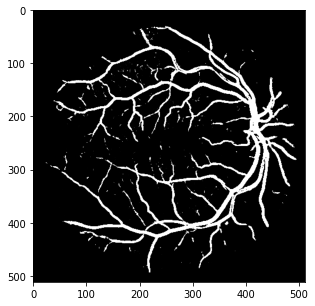

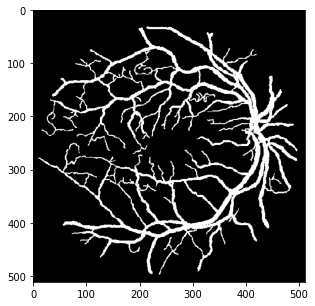

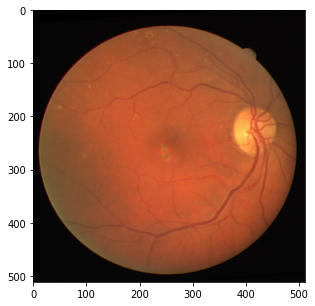

In [15]:
n = 11
# show(decs[n, 1, :, :])
# show(1.0*(decs[n, 0, :, :] < decs[n, 1, :, :]))
show(decs[n, :, :])
show(train_masks[n, :, :])
show(train_images[n, :, :, :])

In [20]:
# Jaccard, Dice, etc. on Train and Test
#
trdecs = decode(model, train_images_tensors, torch.Tensor(train_masks),
                5, torch.device('cuda:0'))
tsdecs = decode(model, test_images_tensors, torch.Tensor(test_masks),
                5, torch.device('cuda:0'))
# pr = 1.0 * (decs > 1.5*decs.mean()).flatten()
for decs, label in zip([trdecs, tsdecs], [train_masks, test_masks]):
    pr = 1.0 * (decs > 0.5*decs.mean()).flatten()
    tg = label.flatten()
    jaccard = sklearn.metrics.jaccard_score(tg, pr)
    dice = 2 * jaccard / (jaccard + 1)
    recall = sklearn.metrics.recall_score(tg, pr)
    precision = sklearn.metrics.precision_score(tg, pr)
    f1score = sklearn.metrics.f1_score(tg, pr)
    print(f'Jaccard: {jaccard:.4f}, Dice: {dice:.4f}, ' + 
          f'Recall: {recall:.4f}, Precision: {precision:.4f}, ' +
          f'F1-score: {f1score:.4f}')

Jaccard: 0.6888, Dice: 0.8157, Recall: 0.7992, Precision: 0.8330, F1-score: 0.8157
Jaccard: 0.6600, Dice: 0.7951, Recall: 0.7744, Precision: 0.8171, F1-score: 0.7951


In [ ]:
# nl = LocallyNonlinear(
#     neighbor_radius = [0, 1, 2, 2, 3, 3, 5, 5],
#     dilation        = [1, 1, 1, 2, 2, 3, 4, 5],
# #     neighbor_radius = [0, 1, 1, 2, 2, 3, 3, 5, 5],
# #     dilation        = [1, 1, 2, 1, 2, 1, 2, 3, 5],
#     ochannel=32, drout=0.0)

# Best loss is 0.3747.
# 0.6890972309496879 0.815935540385968
# Jaccard: 0.6888, Dice: 0.8157, Recall: 0.7992, Precision: 0.8330, F1-score: 0.8157
# Jaccard: 0.6600, Dice: 0.7951, Recall: 0.7744, Precision: 0.8171, F1-score: 0.7951
# Finished in 9278 seconds.